# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


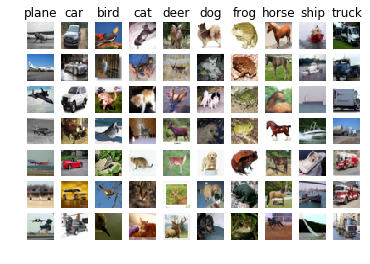

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


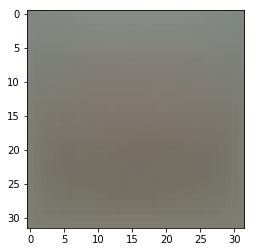

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0) # => along the row => for every pixels
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.782677


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 27.239762 analytic: 27.239762, relative error: 5.237103e-12
numerical: -5.450452 analytic: -5.450452, relative error: 1.985460e-11
numerical: -12.469520 analytic: -12.469520, relative error: 6.729760e-12
numerical: 11.603964 analytic: 11.603964, relative error: 3.659239e-11
numerical: -8.656184 analytic: -8.656184, relative error: 3.495322e-11
numerical: 27.239762 analytic: 27.239762, relative error: 5.237103e-12
numerical: -10.562109 analytic: -10.562109, relative error: 5.192931e-11
numerical: 12.031477 analytic: 12.031477, relative error: 2.193421e-11
numerical: -48.433978 analytic: -48.433978, relative error: 1.286654e-11
numerical: -17.861696 analytic: -17.861696, relative error: 2.834641e-12
numerical: -34.849225 analytic: -34.849225, relative error: 5.149562e-12
numerical: 16.377422 analytic: 16.377422, relative error: 1.136310e-11
numerical: -9.898222 analytic: -9.898222, relative error: 3.127856e-11
numerical: -8.170044 analytic: -8.170044, relative error: 1.862914e

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [20]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.782677e+00 computed in 0.177781s
Vectorized loss: 9.782677e+00 computed in 0.002516s
difference: 0.000000


In [34]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.177574s
Vectorized loss and gradient: computed in 0.010745s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [56]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 770.124935
iteration 100 / 1500: loss 282.759946
iteration 200 / 1500: loss 105.982927
iteration 300 / 1500: loss 42.448672
iteration 400 / 1500: loss 19.100496
iteration 500 / 1500: loss 10.413990
iteration 600 / 1500: loss 6.793504
iteration 700 / 1500: loss 6.137853
iteration 800 / 1500: loss 5.292765
iteration 900 / 1500: loss 5.407442
iteration 1000 / 1500: loss 5.159666
iteration 1100 / 1500: loss 5.016267
iteration 1200 / 1500: loss 5.172915
iteration 1300 / 1500: loss 5.227223
iteration 1400 / 1500: loss 5.809973
That took 11.053232s


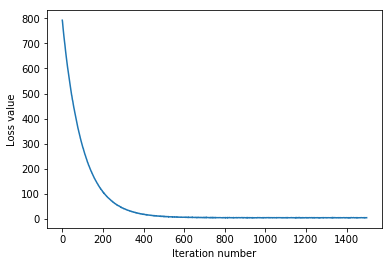

In [41]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [57]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370122
validation accuracy: 0.387000


In [92]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1.137483e-08, 6.137483e-08] # 4.137483e-08 good
regularization_strengths = [1.557e4, 5.858e4]     # 1.658387e+04 good

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
num_iters = 2000
num_test = 10

#sample_lr = np.random.uniform(learning_rates[0], learning_rates[1], num_test)
#sample_reg = np.random.uniform(regularization_strengths[0], regularization_strengths[1], num_test)
sample_lr = np.linspace(learning_rates[0], learning_rates[1], num_test)
sample_reg = np.linspace(regularization_strengths[0], regularization_strengths[1], num_test)
#sample_reg = [0.0e4]
print(sample_lr)
print(sample_reg)

for lr in sample_lr:
    for reg in sample_reg:
        print("# lr: {}, reg: {}".format(lr, reg))
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=num_iters, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        print("# train_acc: {}, val_acc: {}".format(train_acc, val_acc))
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[1.13748300e-08 1.69303856e-08 2.24859411e-08 2.80414967e-08
 3.35970522e-08 3.91526078e-08 4.47081633e-08 5.02637189e-08
 5.58192744e-08 6.13748300e-08]
[15570.         20348.88888889 25127.77777778 29906.66666667
 34685.55555556 39464.44444444 44243.33333333 49022.22222222
 53801.11111111 58580.        ]
# lr: 1.137483e-08, reg: 15570.0
iteration 0 / 2000: loss 496.911321
iteration 100 / 2000: loss 459.818439
iteration 200 / 2000: loss 427.646981
iteration 300 / 2000: loss 397.138763
iteration 400 / 2000: loss 370.232775
iteration 500 / 2000: loss 344.483378
iteration 600 / 2000: loss 320.186299
iteration 700 / 2000: loss 298.753498
iteration 800 / 2000: loss 278.469232
iteration 900 / 2000: loss 258.958097
iteration 1000 / 2000: loss 240.465365
iteration 1100 / 2000: loss 226.035420
iteration 1200 / 2000: loss 209.735250
iteration 1300 / 2000: loss 196.064360
iteration 1400 / 2000: loss 182.532349
iteration 1500 / 2000: loss 169.585828
iteration 1600 / 2000: loss 158.144189
iteratio

iteration 400 / 2000: loss 621.530667
iteration 500 / 2000: loss 475.700124
iteration 600 / 2000: loss 365.853927
iteration 700 / 2000: loss 281.174445
iteration 800 / 2000: loss 215.786898
iteration 900 / 2000: loss 167.000193
iteration 1000 / 2000: loss 128.834479
iteration 1100 / 2000: loss 99.956722
iteration 1200 / 2000: loss 77.619557
iteration 1300 / 2000: loss 61.038261
iteration 1400 / 2000: loss 47.803140
iteration 1500 / 2000: loss 37.619771
iteration 1600 / 2000: loss 30.119930
iteration 1700 / 2000: loss 24.674549
iteration 1800 / 2000: loss 19.933794
iteration 1900 / 2000: loss 16.241555
# train_acc: 0.3523265306122449, val_acc: 0.36
# lr: 1.6930385555555556e-08, reg: 15570.0
iteration 0 / 2000: loss 496.812231
iteration 100 / 2000: loss 439.843617
iteration 200 / 2000: loss 393.700854
iteration 300 / 2000: loss 354.414119
iteration 400 / 2000: loss 320.024070
iteration 500 / 2000: loss 289.010970
iteration 600 / 2000: loss 258.512695
iteration 700 / 2000: loss 232.647849

iteration 1600 / 2000: loss 10.411216
iteration 1700 / 2000: loss 9.123146
iteration 1800 / 2000: loss 7.702678
iteration 1900 / 2000: loss 7.497892
# train_acc: 0.36189795918367346, val_acc: 0.375
# lr: 1.6930385555555556e-08, reg: 58580.0
iteration 0 / 2000: loss 1799.727873
iteration 100 / 2000: loss 1207.767916
iteration 200 / 2000: loss 812.008412
iteration 300 / 2000: loss 546.534999
iteration 400 / 2000: loss 368.030135
iteration 500 / 2000: loss 249.173188
iteration 600 / 2000: loss 168.639262
iteration 700 / 2000: loss 115.059705
iteration 800 / 2000: loss 79.965850
iteration 900 / 2000: loss 54.453380
iteration 1000 / 2000: loss 38.868044
iteration 1100 / 2000: loss 27.839846
iteration 1200 / 2000: loss 20.258242
iteration 1300 / 2000: loss 15.447006
iteration 1400 / 2000: loss 12.280670
iteration 1500 / 2000: loss 10.406988
iteration 1600 / 2000: loss 8.208100
iteration 1700 / 2000: loss 7.298892
iteration 1800 / 2000: loss 6.852010
iteration 1900 / 2000: loss 6.727148
# tra

iteration 700 / 2000: loss 59.853107
iteration 800 / 2000: loss 39.014857
iteration 900 / 2000: loss 25.887443
iteration 1000 / 2000: loss 18.040446
iteration 1100 / 2000: loss 13.191511
iteration 1200 / 2000: loss 10.427795
iteration 1300 / 2000: loss 8.147027
iteration 1400 / 2000: loss 7.777231
iteration 1500 / 2000: loss 7.384800
iteration 1600 / 2000: loss 6.004672
iteration 1700 / 2000: loss 5.881556
iteration 1800 / 2000: loss 5.541656
iteration 1900 / 2000: loss 5.771916
# train_acc: 0.36028571428571426, val_acc: 0.374
# lr: 2.248594111111111e-08, reg: 58580.0
iteration 0 / 2000: loss 1836.788447
iteration 100 / 2000: loss 1077.447404
iteration 200 / 2000: loss 636.556090
iteration 300 / 2000: loss 376.695127
iteration 400 / 2000: loss 223.698773
iteration 500 / 2000: loss 134.888301
iteration 600 / 2000: loss 80.947734
iteration 700 / 2000: loss 50.303460
iteration 800 / 2000: loss 31.798377
iteration 900 / 2000: loss 21.249926
iteration 1000 / 2000: loss 14.746465
iteration 1

iteration 100 / 2000: loss 910.410022
iteration 200 / 2000: loss 499.136700
iteration 300 / 2000: loss 272.816213
iteration 400 / 2000: loss 152.743484
iteration 500 / 2000: loss 85.369163
iteration 600 / 2000: loss 49.533496
iteration 700 / 2000: loss 29.494886
iteration 800 / 2000: loss 18.422155
iteration 900 / 2000: loss 12.817268
iteration 1000 / 2000: loss 9.146168
iteration 1100 / 2000: loss 8.091816
iteration 1200 / 2000: loss 7.373759
iteration 1300 / 2000: loss 5.865530
iteration 1400 / 2000: loss 6.132026
iteration 1500 / 2000: loss 5.773609
iteration 1600 / 2000: loss 5.687754
iteration 1700 / 2000: loss 5.569160
iteration 1800 / 2000: loss 6.199429
iteration 1900 / 2000: loss 5.632554
# train_acc: 0.36251020408163265, val_acc: 0.372
# lr: 2.8041496666666663e-08, reg: 58580.0
iteration 0 / 2000: loss 1821.414135
iteration 100 / 2000: loss 937.511989
iteration 200 / 2000: loss 487.161762
iteration 300 / 2000: loss 254.640772
iteration 400 / 2000: loss 134.098779
iteration 50

iteration 1700 / 2000: loss 5.460580
iteration 1800 / 2000: loss 5.484763
iteration 1900 / 2000: loss 5.457890
# train_acc: 0.35914285714285715, val_acc: 0.371
# lr: 3.359705222222222e-08, reg: 53801.11111111111
iteration 0 / 2000: loss 1682.783517
iteration 100 / 2000: loss 810.100620
iteration 200 / 2000: loss 393.539783
iteration 300 / 2000: loss 192.192888
iteration 400 / 2000: loss 96.502902
iteration 500 / 2000: loss 49.383688
iteration 600 / 2000: loss 26.818246
iteration 700 / 2000: loss 15.338438
iteration 800 / 2000: loss 10.493635
iteration 900 / 2000: loss 8.342492
iteration 1000 / 2000: loss 6.834599
iteration 1100 / 2000: loss 6.434407
iteration 1200 / 2000: loss 5.782892
iteration 1300 / 2000: loss 6.417500
iteration 1400 / 2000: loss 6.288051
iteration 1500 / 2000: loss 5.415392
iteration 1600 / 2000: loss 5.165568
iteration 1700 / 2000: loss 6.040262
iteration 1800 / 2000: loss 5.210260
iteration 1900 / 2000: loss 5.491583
# train_acc: 0.3601020408163265, val_acc: 0.37

iteration 1100 / 2000: loss 5.918731
iteration 1200 / 2000: loss 5.598959
iteration 1300 / 2000: loss 5.545562
iteration 1400 / 2000: loss 6.108832
iteration 1500 / 2000: loss 5.441422
iteration 1600 / 2000: loss 5.487191
iteration 1700 / 2000: loss 5.888035
iteration 1800 / 2000: loss 5.187226
iteration 1900 / 2000: loss 5.295842
# train_acc: 0.3619591836734694, val_acc: 0.382
# lr: 3.915260777777778e-08, reg: 53801.11111111111
iteration 0 / 2000: loss 1673.811872
iteration 100 / 2000: loss 716.274528
iteration 200 / 2000: loss 310.460428
iteration 300 / 2000: loss 136.440277
iteration 400 / 2000: loss 61.175652
iteration 500 / 2000: loss 29.832490
iteration 600 / 2000: loss 16.069321
iteration 700 / 2000: loss 9.874145
iteration 800 / 2000: loss 6.950482
iteration 900 / 2000: loss 6.016709
iteration 1000 / 2000: loss 5.831911
iteration 1100 / 2000: loss 5.571750
iteration 1200 / 2000: loss 5.737790
iteration 1300 / 2000: loss 5.046152
iteration 1400 / 2000: loss 5.520802
iteration 15

iteration 500 / 2000: loss 23.609633
iteration 600 / 2000: loss 13.377400
iteration 700 / 2000: loss 9.332771
iteration 800 / 2000: loss 6.686246
iteration 900 / 2000: loss 5.772563
iteration 1000 / 2000: loss 5.643006
iteration 1100 / 2000: loss 5.708179
iteration 1200 / 2000: loss 5.628665
iteration 1300 / 2000: loss 5.622316
iteration 1400 / 2000: loss 5.314952
iteration 1500 / 2000: loss 5.721848
iteration 1600 / 2000: loss 5.526038
iteration 1700 / 2000: loss 6.048570
iteration 1800 / 2000: loss 5.721756
iteration 1900 / 2000: loss 5.261359
# train_acc: 0.3621632653061225, val_acc: 0.383
# lr: 4.470816333333333e-08, reg: 53801.11111111111
iteration 0 / 2000: loss 1665.910124
iteration 100 / 2000: loss 634.856315
iteration 200 / 2000: loss 243.439326
iteration 300 / 2000: loss 96.256373
iteration 400 / 2000: loss 40.085303
iteration 500 / 2000: loss 18.271856
iteration 600 / 2000: loss 10.901520
iteration 700 / 2000: loss 7.806930
iteration 800 / 2000: loss 6.569849
iteration 900 /

iteration 100 / 2000: loss 573.741906
iteration 200 / 2000: loss 215.863849
iteration 300 / 2000: loss 83.328910
iteration 400 / 2000: loss 33.962359
iteration 500 / 2000: loss 15.959854
iteration 600 / 2000: loss 10.076855
iteration 700 / 2000: loss 7.104129
iteration 800 / 2000: loss 6.000566
iteration 900 / 2000: loss 5.399194
iteration 1000 / 2000: loss 5.479993
iteration 1100 / 2000: loss 5.788754
iteration 1200 / 2000: loss 5.753628
iteration 1300 / 2000: loss 5.420722
iteration 1400 / 2000: loss 5.539137
iteration 1500 / 2000: loss 5.531550
iteration 1600 / 2000: loss 5.534809
iteration 1700 / 2000: loss 5.989313
iteration 1800 / 2000: loss 5.687471
iteration 1900 / 2000: loss 5.362769
# train_acc: 0.3641020408163265, val_acc: 0.376
# lr: 5.0263718888888884e-08, reg: 53801.11111111111
iteration 0 / 2000: loss 1656.921487
iteration 100 / 2000: loss 559.711196
iteration 200 / 2000: loss 191.191147
iteration 300 / 2000: loss 67.961472
iteration 400 / 2000: loss 26.867419
iteration 

iteration 1900 / 2000: loss 5.521458
# train_acc: 0.3607959183673469, val_acc: 0.375
# lr: 5.581927444444444e-08, reg: 49022.22222222222
iteration 0 / 2000: loss 1514.327427
iteration 100 / 2000: loss 505.124691
iteration 200 / 2000: loss 171.541915
iteration 300 / 2000: loss 60.904729
iteration 400 / 2000: loss 23.550039
iteration 500 / 2000: loss 11.631322
iteration 600 / 2000: loss 7.375314
iteration 700 / 2000: loss 5.972092
iteration 800 / 2000: loss 5.992581
iteration 900 / 2000: loss 5.358546
iteration 1000 / 2000: loss 6.085187
iteration 1100 / 2000: loss 6.380207
iteration 1200 / 2000: loss 5.683885
iteration 1300 / 2000: loss 5.522368
iteration 1400 / 2000: loss 5.853870
iteration 1500 / 2000: loss 5.733313
iteration 1600 / 2000: loss 5.841116
iteration 1700 / 2000: loss 5.771951
iteration 1800 / 2000: loss 5.651144
iteration 1900 / 2000: loss 5.932871
# train_acc: 0.36144897959183675, val_acc: 0.365
# lr: 5.581927444444444e-08, reg: 53801.11111111111
iteration 0 / 2000: loss

iteration 1600 / 2000: loss 5.421323
iteration 1700 / 2000: loss 5.150274
iteration 1800 / 2000: loss 5.448137
iteration 1900 / 2000: loss 5.547576
# train_acc: 0.3607142857142857, val_acc: 0.372
# lr: 6.137483e-08, reg: 49022.22222222222
iteration 0 / 2000: loss 1538.393163
iteration 100 / 2000: loss 458.484414
iteration 200 / 2000: loss 140.327081
iteration 300 / 2000: loss 45.379605
iteration 400 / 2000: loss 17.187229
iteration 500 / 2000: loss 8.625373
iteration 600 / 2000: loss 6.782797
iteration 700 / 2000: loss 5.692236
iteration 800 / 2000: loss 5.341349
iteration 900 / 2000: loss 5.529725
iteration 1000 / 2000: loss 5.107884
iteration 1100 / 2000: loss 5.184178
iteration 1200 / 2000: loss 5.381712
iteration 1300 / 2000: loss 5.240684
iteration 1400 / 2000: loss 5.427961
iteration 1500 / 2000: loss 5.699566
iteration 1600 / 2000: loss 5.590229
iteration 1700 / 2000: loss 5.140784
iteration 1800 / 2000: loss 5.208280
iteration 1900 / 2000: loss 5.815153
# train_acc: 0.357775510

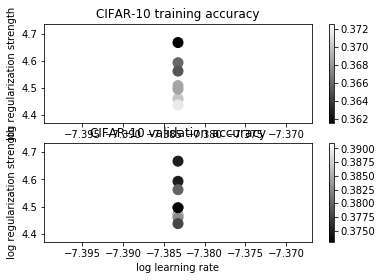

In [89]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [90]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


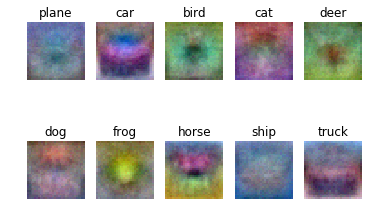

In [91]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*